In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import os, h5py
import tensorflow as tf

from tqdm import tqdm
from numba import njit

from msfm.utils.io import read_yaml

In this notebook, different ways to calculate the underlying number of galaxies per pixel for the Metacalibration sample are compared. 

### global constants

In [2]:
conf_dir = "../configs/config.yaml"
conf = read_yaml(conf_dir)

n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]

l_max = 2*n_side

# Metacal tomo bin
tomo_range = range(1, 7)

### functions

In [3]:
def plot_patch(patch, title=""):
    patch_plot = patch.copy()
    patch_plot[patch == 0] = hp.UNSEEN

    hp.mollview(patch_plot, title=title)
    hp.graticule()

    hp.gnomview(patch_plot, title=title)

    print(f"n_gal = {np.sum(patch):.4e}")

# Catalog

### Maglim

In [4]:
index_dir = "/Users/arne/data/DESY3/public/DESY3_indexcat.h5"
with h5py.File(index_dir, "r") as f:
    indices_metacal = f["index/metacal/select"][:]
    indices_maglim = f["index/maglim/select"][:]


dnf_dir = "/Users/arne/data/DESY3/public/DESY3_GOLD_2_2.1_DNF.h5"
with h5py.File(dnf_dir, "r") as f:
    z_metacal = f["catalog/unsheared/zmean_sof"][:][indices_metacal]
    z_maglim = f["catalog/unsheared/zmean_sof"][:][indices_maglim]


# redshift bin definitions
z_mask_metacal = (0.0 < z_metacal) & (z_metacal < 2.0)
z_mask_maglim = (0.2 < z_maglim) & (z_maglim < 1.05)

indices_metacal = indices_metacal[z_mask_metacal]
indices_maglim = indices_maglim[z_mask_maglim]

index_intersect = np.intersect1d(indices_metacal, indices_maglim)
print(f"intersection {len(index_intersect):.4e}")

print(f"total metacal {len(indices_metacal):.4e}")
print(f"total maglim {len(indices_maglim):.4e}")

intersection 9.6856e+06
total metacal 1.2302e+08
total maglim 1.0717e+07


In [5]:
index_dir = "/Users/arne/data/DESY3/public/DESY3_indexcat.h5"
with h5py.File(index_dir, "r") as f:
    indices_maglim = f["index/maglim/select"][:]

maglim_dir = "/Users/arne/data/DESY3/public/DESY3_maglim_redmagic_v0.5.1.h5"
with h5py.File(maglim_dir, "r") as catalog_ml:
    dec_maglim_deg = catalog_ml['catalog/maglim/dec'][:]
    ra_maglim_deg = catalog_ml['catalog/maglim/ra'][:]
    w_maglim = catalog_ml['catalog/maglim/weight'][:]

dnf_dir = "/Users/arne/data/DESY3/public/DESY3_GOLD_2_2.1_DNF.h5"
with h5py.File(dnf_dir, "r") as f:
    z_mean = f["catalog/unsheared/zmean_sof"][:][indices_maglim]

# redshift bin definitions
z_mask_tot = (0.2 < z_mean) & (z_mean < 1.05)
z_masks = [
    (0.2 < z_mean) & (z_mean < 0.4),
    (0.4 < z_mean) & (z_mean < 0.55),
    (0.55 < z_mean) & (z_mean < 0.70),
    (0.70 < z_mean) & (z_mean < 0.85),
    (0.85 < z_mean) & (z_mean < 0.95),
    (0.95 < z_mean) & (z_mean < 1.05),
]

# reduce the gold catalog to the MagLim sample
dec_maglim_deg_all = dec_maglim_deg[indices_maglim]
ra_maglim_deg_all = ra_maglim_deg[indices_maglim]
w_maglim_all = w_maglim[indices_maglim]

maglim_counts_tomo = []
maglim_patch_pix_tomo = []
n_bar_tomo = []
for i, tomo in enumerate(tomo_range):
    print(f"tomo bin {tomo}")
    # apply redshift cut to the maglim sample
    redshift_mask = z_masks[i]
    dec_maglim_deg = dec_maglim_deg_all[redshift_mask]
    ra_maglim_deg = ra_maglim_deg_all[redshift_mask]
    w_maglim = w_maglim_all[redshift_mask]

    assert dec_maglim_deg.shape == ra_maglim_deg.shape == w_maglim.shape

    # angles like in healpy in radian
    theta_maglim = - dec_maglim_deg * np.pi/180 + np.pi/2
    phi_maglim = ra_maglim_deg * np.pi/180

    # galaxy level: derived pixel ids, shape (num_galaxies,)
    maglim_inds = hp.ang2pix(nside=n_side, theta=theta_maglim, phi=phi_maglim)

    # pixel level: derived pixel ids and number of galaxies per pixel
    maglim_patch_pix, maglim_n_gal = np.unique(maglim_inds, return_counts=True)

    # mean number of galaxies per pixel
    n_bar = len(maglim_inds)/len(maglim_patch_pix)
    print(f"n_gal = {len(maglim_inds):.4f} [galaxies]")
    print(f"n_bar = {n_bar:.4f} [galaxies/pixel]")

    # number of galaxies per pixel
    maglim_counts = np.zeros(n_pix)
    maglim_counts[maglim_patch_pix] = maglim_n_gal

    maglim_counts_tomo.append(maglim_counts)
    maglim_patch_pix_tomo.append(maglim_patch_pix)
    n_bar_tomo.append(n_bar)

tomo bin 1
n_gal = 2236473.0000 [galaxies]
n_bar = 6.2102 [galaxies/pixel]
tomo bin 2
n_gal = 1599500.0000 [galaxies]
n_bar = 4.5499 [galaxies/pixel]
tomo bin 3
n_gal = 1627413.0000 [galaxies]
n_bar = 4.6422 [galaxies/pixel]
tomo bin 4
n_gal = 2175184.0000 [galaxies]
n_bar = 6.0268 [galaxies/pixel]
tomo bin 5
n_gal = 1583686.0000 [galaxies]
n_bar = 4.4816 [galaxies/pixel]
tomo bin 6
n_gal = 1494250.0000 [galaxies]
n_bar = 4.2513 [galaxies/pixel]


# N-body

### load a Maglim like simulated delta map

In [6]:
# according to Marco this should be alright
maglim_bias_tomo = [1.4, 1.6, 1.8, 1.7, 1.9, 1.7]
# maglim_bias_tomo = [1, 1, 1, 1, 1, 1, 1]

In [7]:
# load fiducial cosmology
projected_maps_dir = "/Users/arne/data/CosmoGrid_example/DES/Fiducial/perm_0000/projected_probes_maps_nobaryons512.h5"

sim_counts_tomo = []
noisy_sim_counts_tomo = []
for i, tomo in enumerate(tomo_range):
    patch_pix = maglim_patch_pix_tomo[i]
    anti_patch_pix = np.setdiff1d(np.arange(n_pix), patch_pix)

    maglim_bias_tomo
    with h5py.File(projected_maps_dir, "r") as f:
        dg_map = f[f"dg/desy3maglim{tomo}"][:]

    # normalize the number density contrast
    dg_map = (dg_map - np.mean(dg_map))/np.mean(dg_map)

    # number of galaxies per pixel
    sim_counts = (1+maglim_bias_tomo[i]*dg_map)*n_bar_tomo[i]
    noisy_sim_counts = np.random.poisson(sim_counts)
    noisy_sim_counts = noisy_sim_counts.astype(np.float32)

    # apply masking
    sim_counts[anti_patch_pix] = 0
    noisy_sim_counts[anti_patch_pix] = 0

    sim_counts_tomo.append(sim_counts)
    noisy_sim_counts_tomo.append(noisy_sim_counts)

# Comparison

The two last bins, 5 and 6 were removed in the analysis, so probably have problems associated with them.

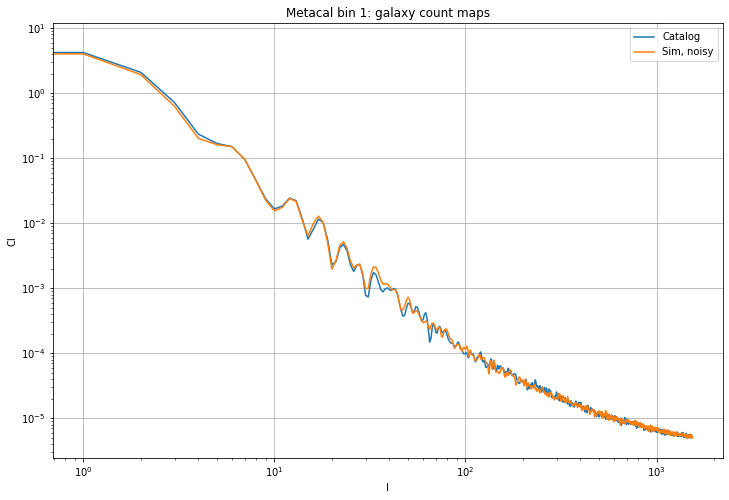

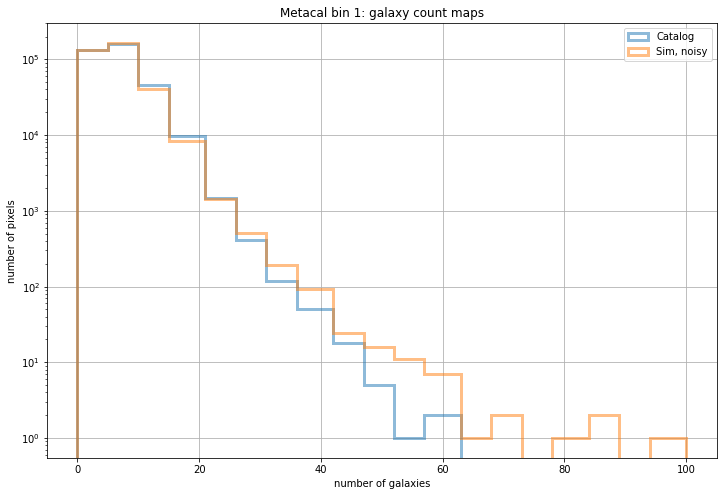

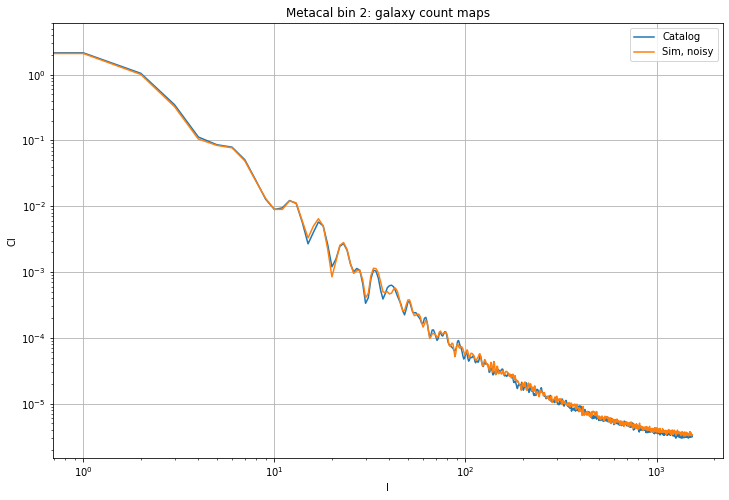

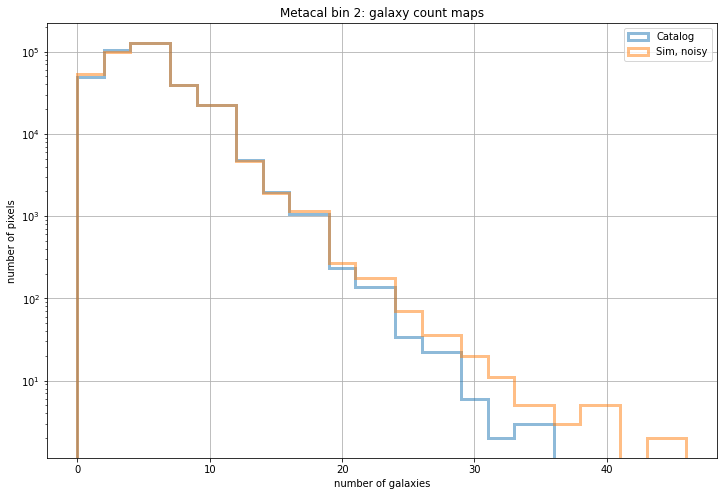

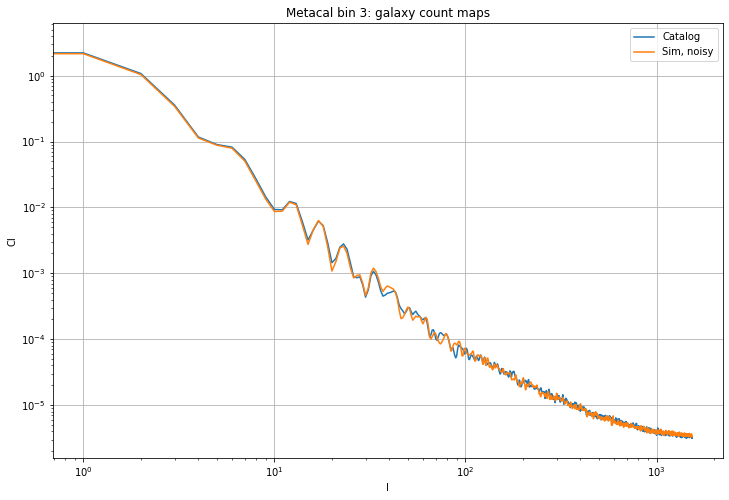

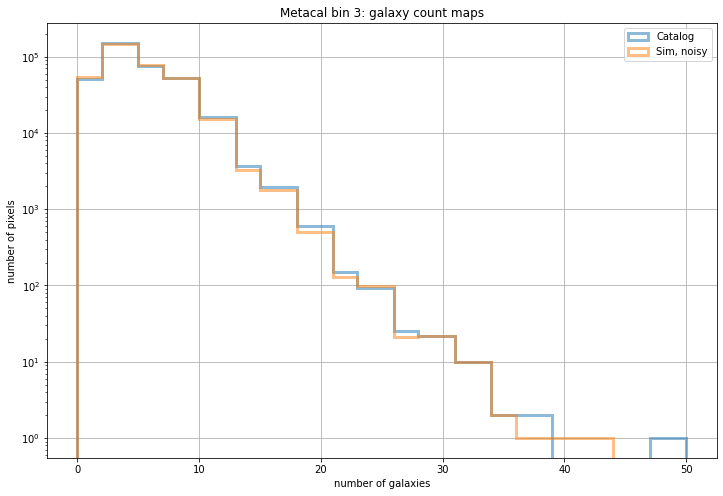

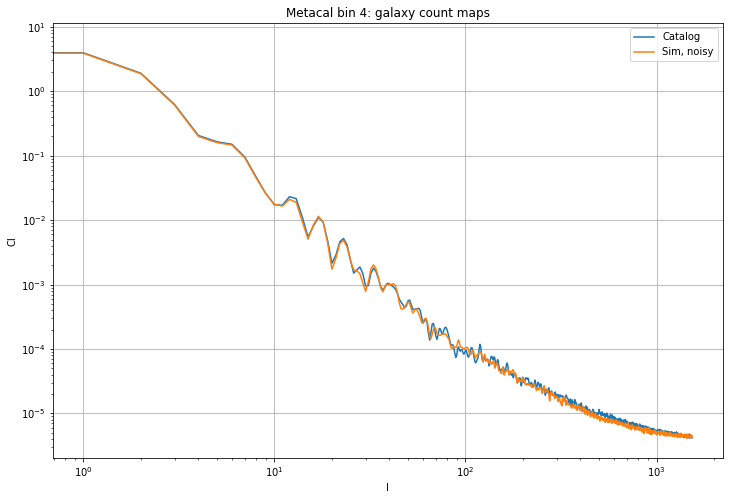

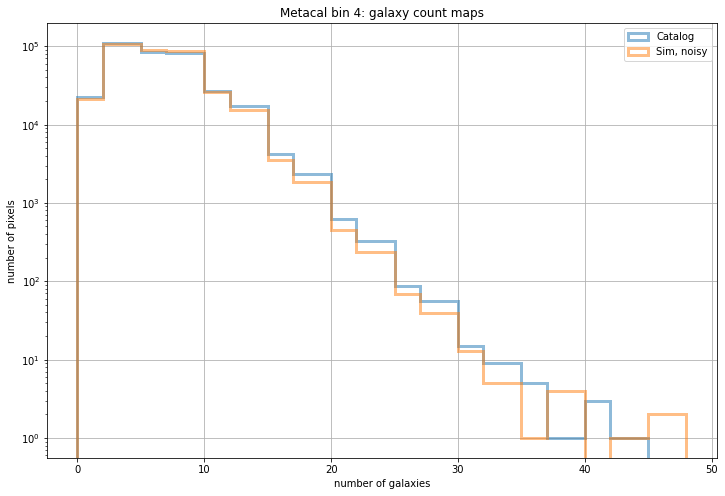

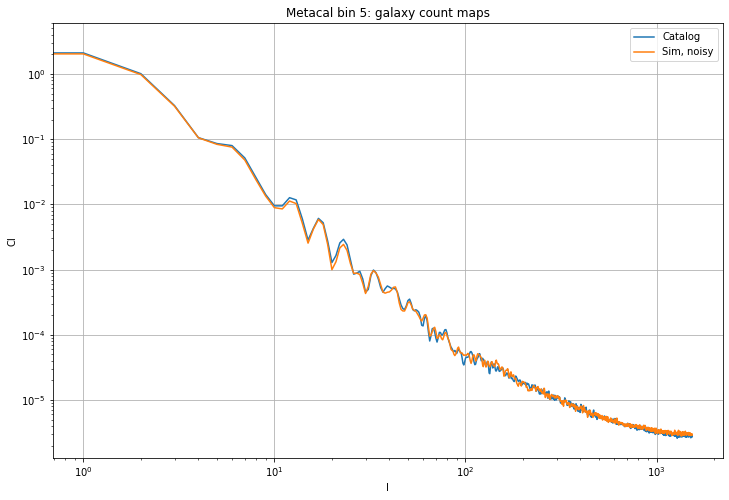

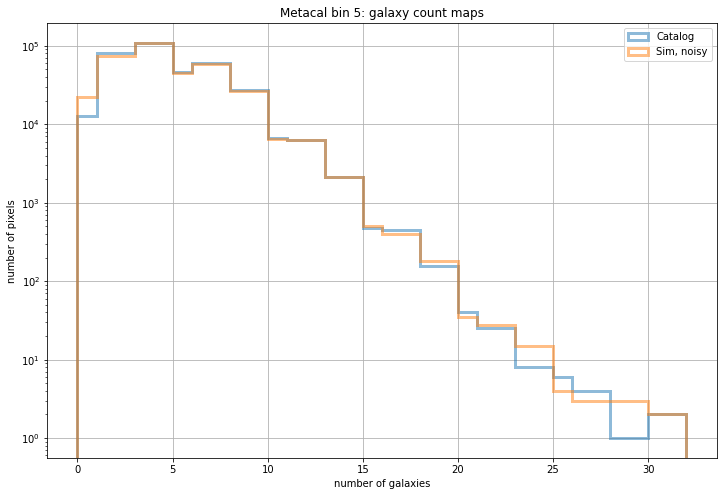

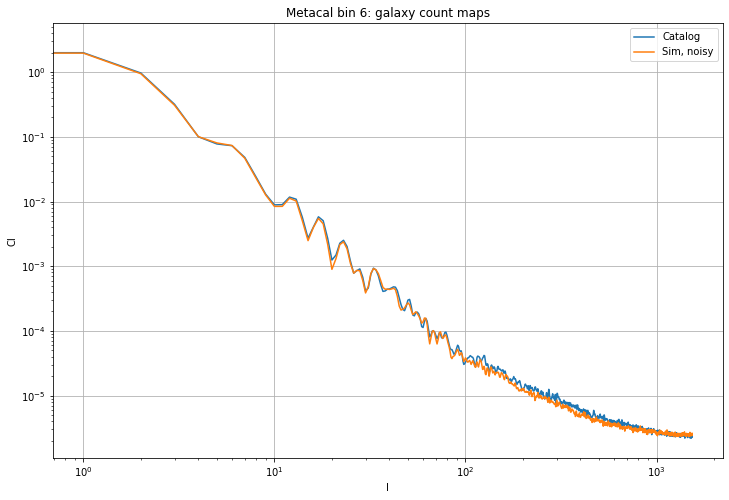

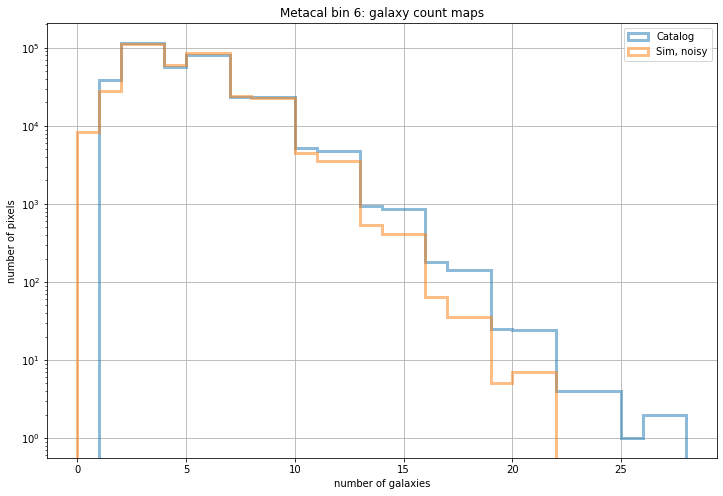

In [8]:
for i, tomo in enumerate(tomo_range):
    count_maps = [
        maglim_counts_tomo[i],
        # sim_counts_tomo[i],
        noisy_sim_counts_tomo[i],
    ]
    labels = [
        "Catalog",
        # "Sim, noiseless",
        "Sim, noisy",
    ]

    fig_cls, ax_cls = plt.subplots(figsize=(12,8))

    fig_hist, ax_hist = plt.subplots(figsize=(12,8))
    stacked_maps = np.stack(count_maps)
    bins = np.linspace(stacked_maps.min(), stacked_maps.max(), 20, dtype=int)

    for count_map, label in zip(count_maps, labels):    
        # consider the same patch for all
        count_map[anti_patch_pix] = 0

        cls = hp.anafast(count_map, use_pixel_weights=True)
        ax_cls.loglog(cls, label=label)

        ax_hist.hist(count_map[patch_pix], bins=bins, label=label, alpha=0.5, histtype="step", linewidth=3, log=True)

    ax_cls.legend()
    ax_cls.set(xlabel="l", ylabel="Cl", title=f"Metacal bin {tomo}: galaxy count maps")
    ax_cls.grid(True)

    ax_hist.legend()
    ax_hist.set(xlabel="number of galaxies", ylabel="number of pixels", title=f"Metacal bin {tomo}: galaxy count maps")
    ax_hist.grid(True)